<a href="https://colab.research.google.com/github/contatofe/Estudos-e-Desafios/blob/main/PLN%20-%20IA%20Expert/Classifica%C3%A7%C3%A3o_de_Sentimentos_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa 1: Importação das bibliotecas

In [ ]:
!pip install lxml --quiet

In [40]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [ ]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Etapa 2: Pré-processamento dos dados

## Carregamento dos arquivos

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Arquivos - Dados/PNL - CNN/train.csv', header = None,
                         names = cols, engine = 'python', encoding = 'latin1')

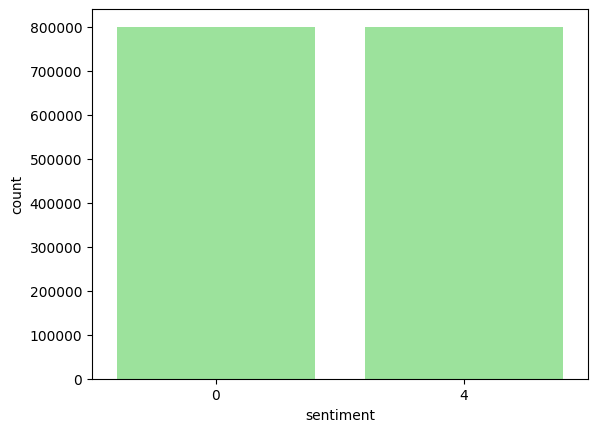

In [ ]:
sns.countplot(x=train_data.sentiment, color='lightgreen');

In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/Arquivos - Dados/PNL - CNN/test.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)

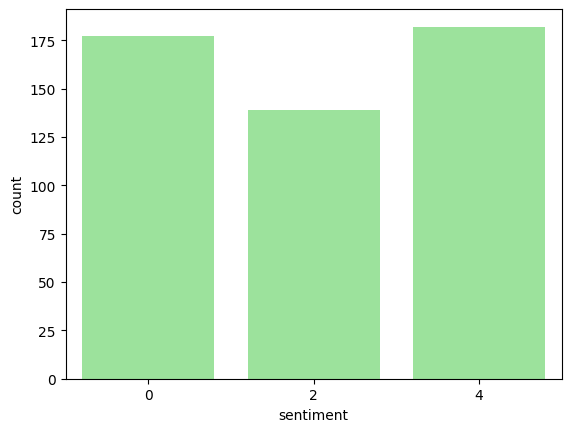

In [ ]:
sns.countplot(x=test_data.sentiment,color = 'lightgreen');

## Pré-processamento

### Limpeza

In [ ]:
data = train_data

In [ ]:
data.drop(['id', 'date', 'query', 'user'], axis = 1, inplace=True)

In [ ]:
X = data.iloc[:, 1].values

In [ ]:
y = data.iloc[:, 0].values

In [ ]:
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y)

In [ ]:
unique, counts = np.unique(y, return_counts=True)

In [ ]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [ ]:
nlp = sp.load('en_core_web_sm')

In [ ]:
stop_words = sp.lang.en.STOP_WORDS

In [ ]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words

In [ ]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]

In [ ]:
data_labels = y

In [ ]:
data_labels[data_labels == 4] = 1

### Tokenização

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [ ]:
ids = tokenizer.encode('i am happy')
ids

[258, 3744, 383]

In [ ]:
text = tokenizer.decode(ids)
text

'i am happy'

In [ ]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

### Padding

In [ ]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

61

In [ ]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

### Divisão da base de dados em treinamento e teste



In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

# Etapa 3: Construção do modelo

In [ ]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training=training) # merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Etapa 4: Treinamento

## Configuração dos parâmetros

In [ ]:
vocab_size = tokenizer.vocab_size

In [ ]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [ ]:
dropout_rate = 0.2
nb_epochs = 5

## Treinamento

In [ ]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [37]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [39]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/5
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.7185 - loss: 0.5370 - val_accuracy: 0.7715 - val_loss: 0.4700
Epoch 2/5
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8420 - loss: 0.3567 - val_accuracy: 0.7690 - val_loss: 0.5069
Epoch 3/5
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.9259 - loss: 0.1800 - val_accuracy: 0.7577 - val_loss: 0.6976
Epoch 4/5
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9632 - loss: 0.0900 - val_accuracy: 0.7435 - val_loss: 0.9659
Epoch 5/5
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9760 - loss: 0.0591 - val_accuracy: 0.7345 - val_loss: 1.2700


'./ckpt-1'

# Etapa 5: Avaliação do modelo

## Avaliação

In [41]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7308 - loss: 1.2988


In [42]:
y_pred_test = Dcnn.predict(test_inputs)

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [43]:
y_pred_test = (y_pred_test > 0.5)

<Axes: >

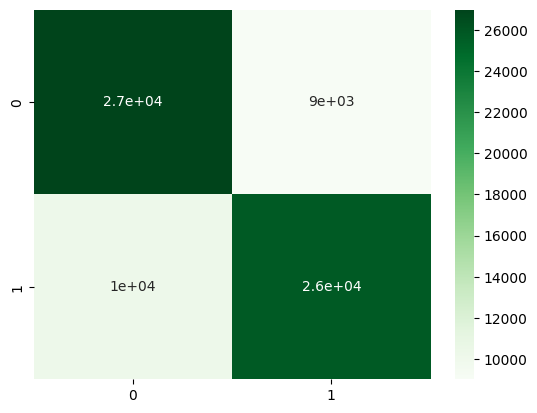

In [44]:
cm = confusion_matrix(test_labels, y_pred_test)
sns.heatmap(cm, annot=True, cmap='Greens')

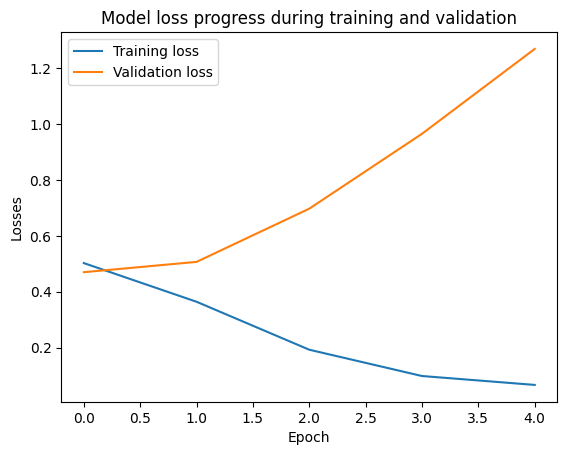

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

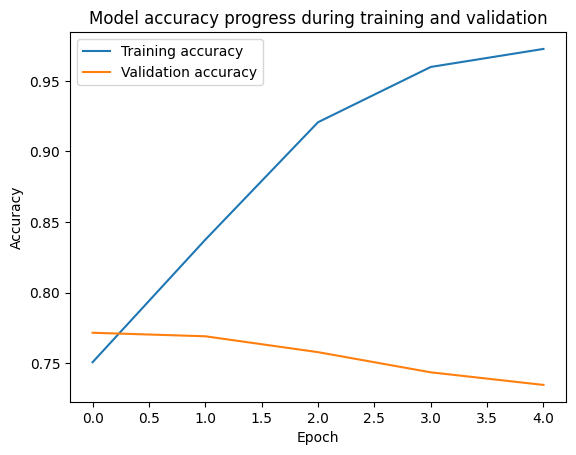

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

## Previsões

In [60]:
text = 'i hate you'
text = tokenizer.encode(text)

prev = Dcnn(np.array([text]), training=False).numpy()
if prev > 0.5:
  print('Positive')
else:
  print('Negative')

Negative
